# Stingray's dead time models

Here we verify that the algorithm used for dead time filtering is behaving as expected.

We also compare the results with the algorithm for paralyzable dead time, for reference.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from stingray import EventList, AveragedPowerspectrum
import tqdm
import stingray.deadtime.model as dz
from stingray.deadtime.model import A, check_A, check_B

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['font.size'] = 18.0
mpl.rcParams['xtick.labelsize'] = 18.0
mpl.rcParams['ytick.labelsize'] = 18.0
mpl.rcParams['axes.labelsize'] = 18.0
mpl.rcParams['axes.labelsize'] = 18.0

from stingray.filters import filter_for_deadtime

import numpy as np
np.random.seed(1209432)

## Non-paralyzable dead time

In [2]:
def simulate_events(rate, length, deadtime=2.5e-3, **filter_kwargs):
    events = np.random.uniform(0, length, int(rate * length))
    events = np.sort(events)
    events_dt = filter_for_deadtime(events, deadtime, **filter_kwargs)
    return events, events_dt

In [3]:
rate = 1000
length = 1000
events, events_dt = simulate_events(rate, length)
diff = np.diff(events)
diff_dt = np.diff(events_dt)

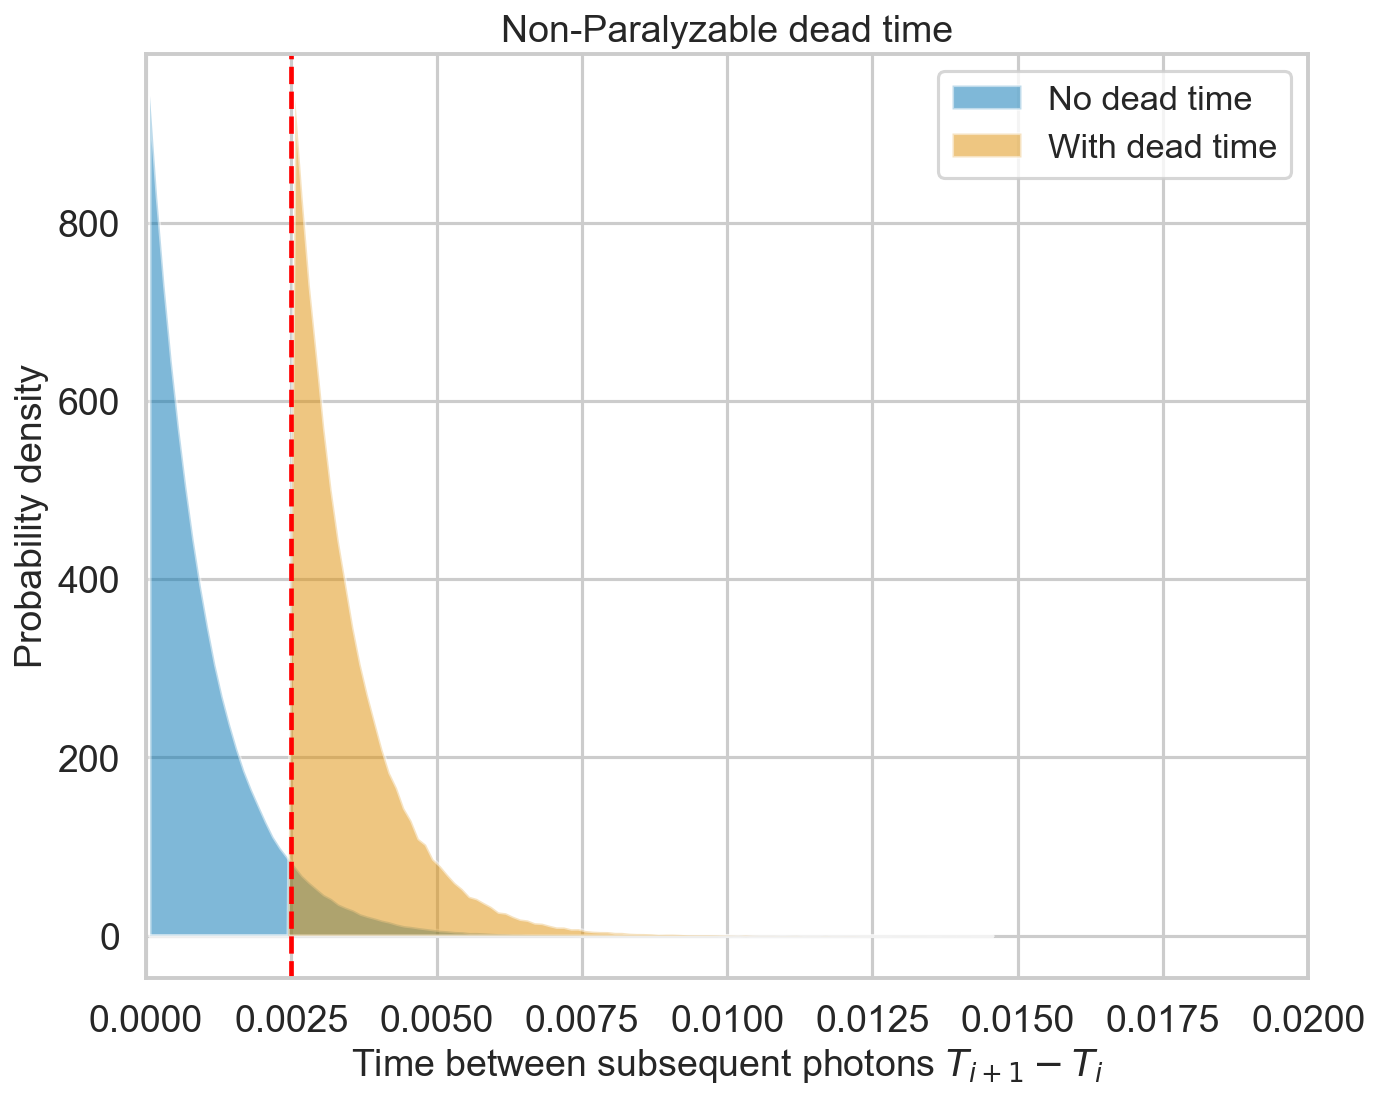

In [4]:
dt = 2.5e-3/20  # an exact fraction of deadtime
bins = np.arange(0, np.max(diff), dt)
hist = np.histogram(diff, bins=bins, density=True)[0]
hist_dt = np.histogram(diff_dt, bins=bins, density=True)[0]

bins_mean = bins[:-1] + dt/2
plt.figure()
plt.title('Non-Paralyzable dead time')

plt.fill_between(bins_mean, 0, hist, alpha=0.5, label='No dead time');
plt.fill_between(bins_mean, 0, hist_dt, alpha=0.5, label='With dead time');

plt.xlim([0, 0.02]);
# plt.ylim([0, 100]);

plt.axvline(2.5e-3, color='r', ls='--')
plt.xlabel(r'Time between subsequent photons $T_{i+1} - T_{i}$')
plt.ylabel('Probability density')

plt.legend();

Exactly as expected, the output distribution of the distance between the events follows an exponential distribution cut at 2.5 ms.

The measured rate is expected to go as 
$$r_{det} = \frac{r_{in}}{1 + r_{in}\tau_d}$$ 
(Zhang+95, eq. 29). Let's check it.

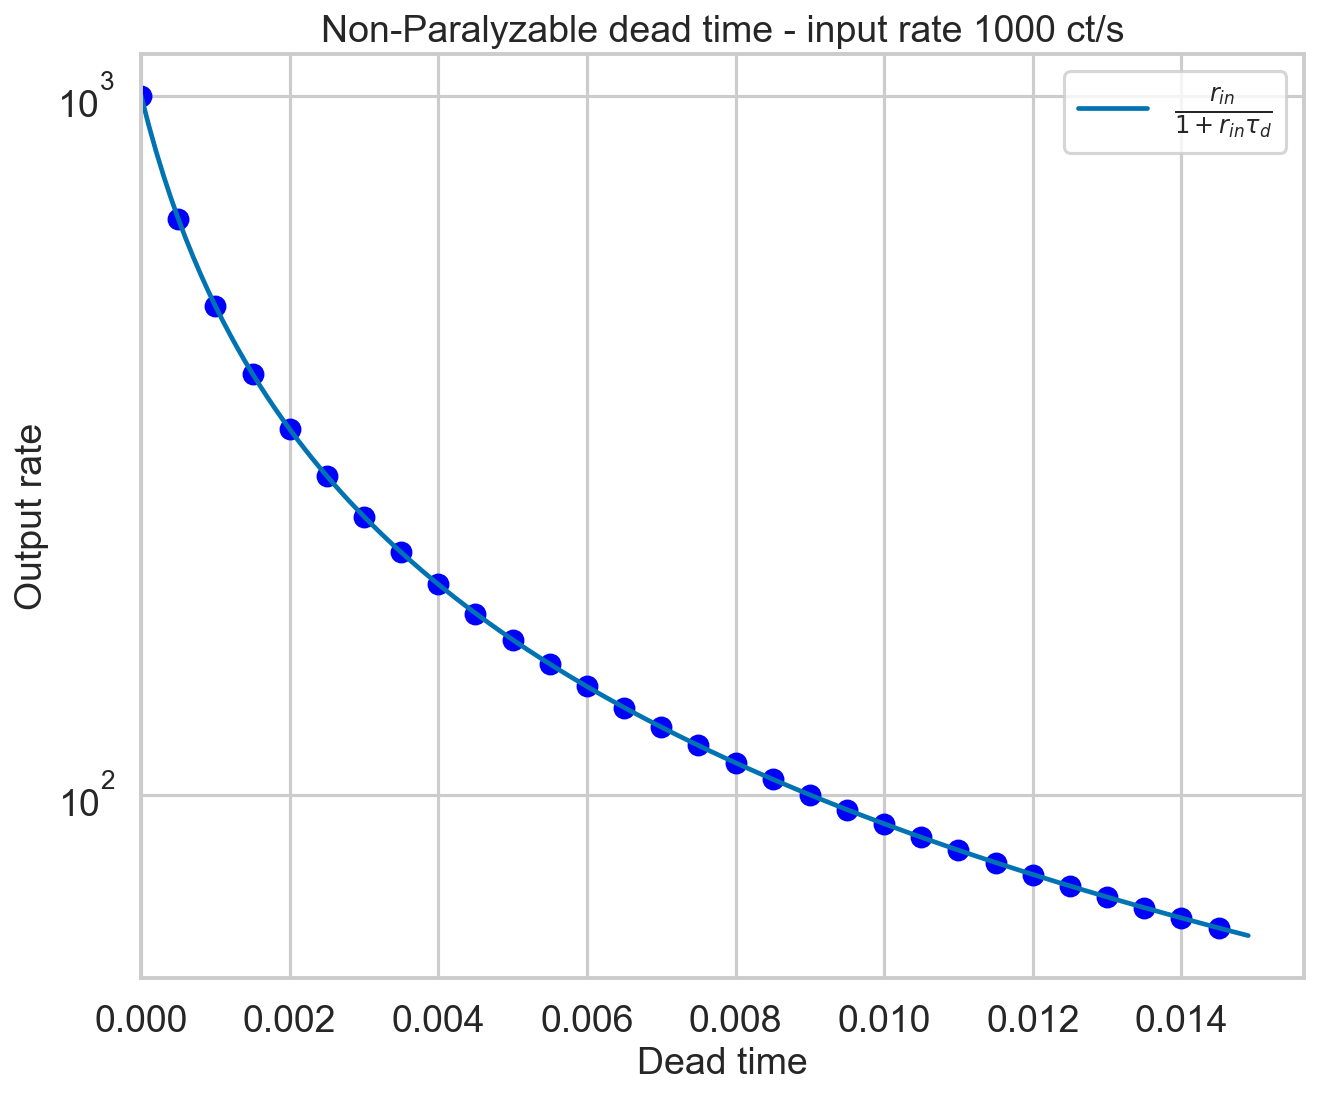

In [5]:
plt.figure()
plt.title('Non-Paralyzable dead time - input rate {} ct/s'.format(rate))

deadtimes = np.arange(0, 0.015, 0.0005)
deadtimes_plot = np.arange(0, 0.015, 0.0001)

for d in deadtimes:
    events_dt = filter_for_deadtime(events, d)
    new_rate = len(events_dt) / length
    plt.scatter(d, new_rate, color='b')

plt.plot(deadtimes_plot, rate / (1 + rate * deadtimes_plot), 
         label=r'$\frac{r_{in}}{1 + r_{in}\tau_d}$')
plt.xlim([0, None])
plt.xlabel('Dead time')
plt.ylabel('Output rate')
plt.semilogy()
plt.legend();

## Paralyzable dead time

In [6]:
rate = 1000
length = 1000
events, events_dt = simulate_events(rate, length, paralyzable=True)
diff = np.diff(events)
diff_dt = np.diff(events_dt)

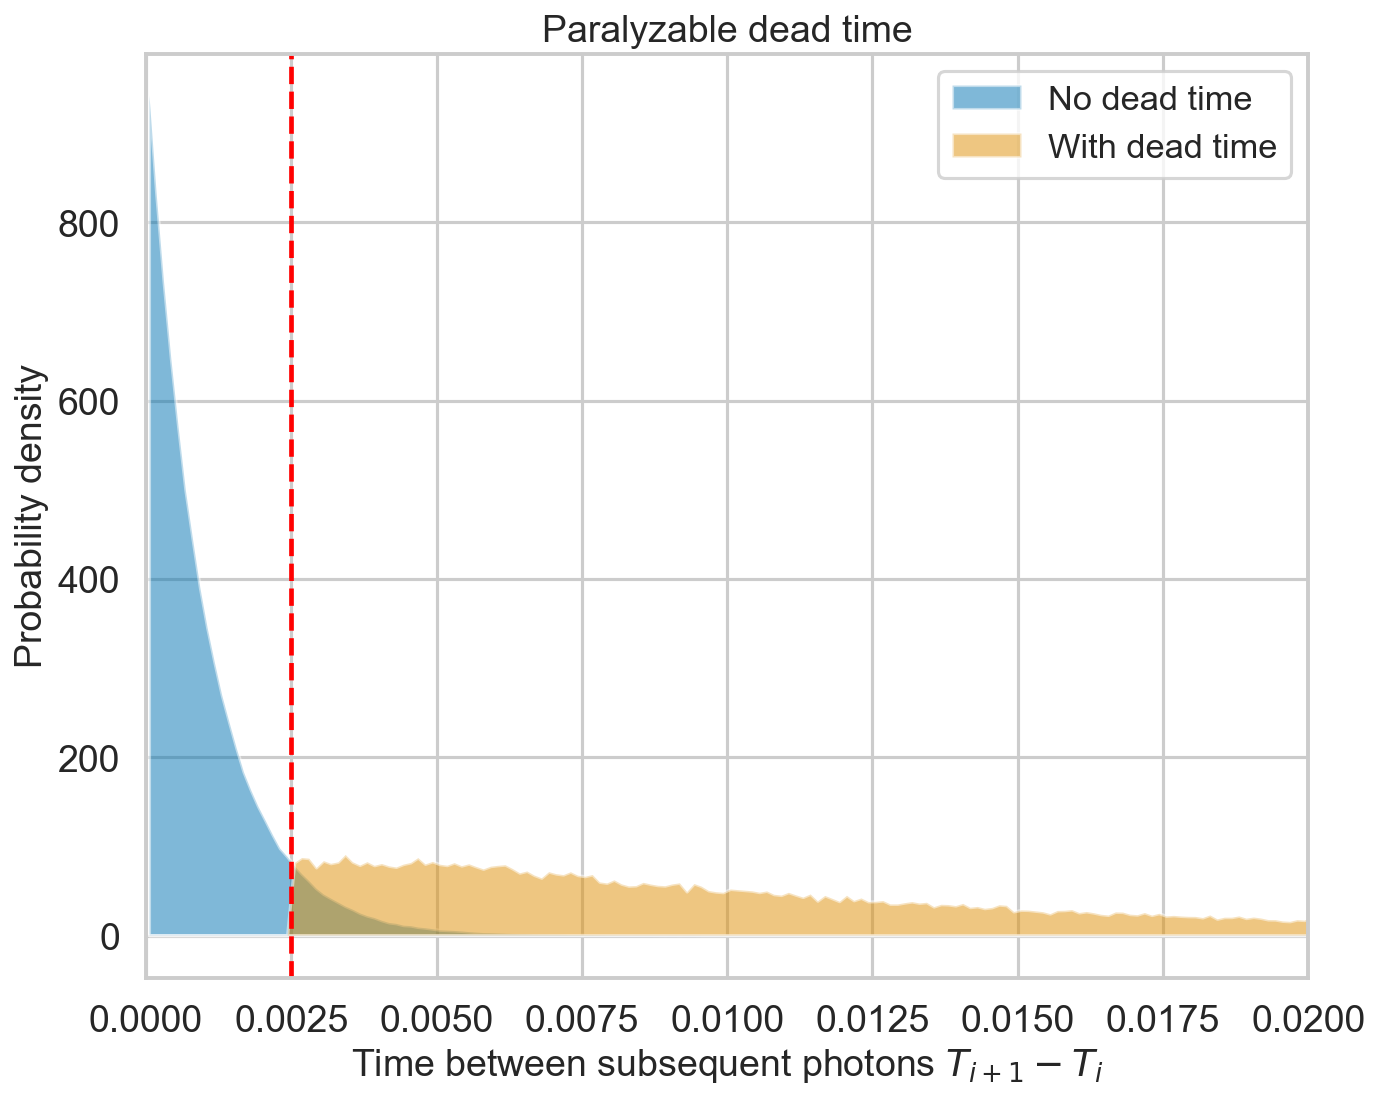

In [7]:
dt = 2.5e-3/20  # an exact fraction of deadtime
bins = np.arange(0, np.max(diff_dt), dt)
hist = np.histogram(diff, bins=bins, density=True)[0]
hist_dt = np.histogram(diff_dt, bins=bins, density=True)[0]

bins_mean = bins[:-1] + dt/2
plt.figure()
plt.title('Paralyzable dead time')
plt.fill_between(bins_mean, 0, hist, alpha=0.5, label='No dead time');
plt.fill_between(bins_mean, 0, hist_dt, alpha=0.5, label='With dead time');
plt.xlim([0, 0.02]);
# plt.ylim([0, 100]);

plt.axvline(2.5e-3, color='r', ls='--')
plt.xlabel(r'Time between subsequent photons $T_{i+1} - T_{i}$')
plt.ylabel('Probability density')

plt.legend();

Non-paralyzable dead time has a distribution for the time between consecutive counts that plateaus between $\tau_d$ and $2\tau_d$, then decreases. The exact form is complicated (e.g. )

The measured rate is expected to go as 
$$r_{det} = r_{in}e^{-r_{in}\tau_d}$$
(Zhang+95, eq. 16). Let's check it.

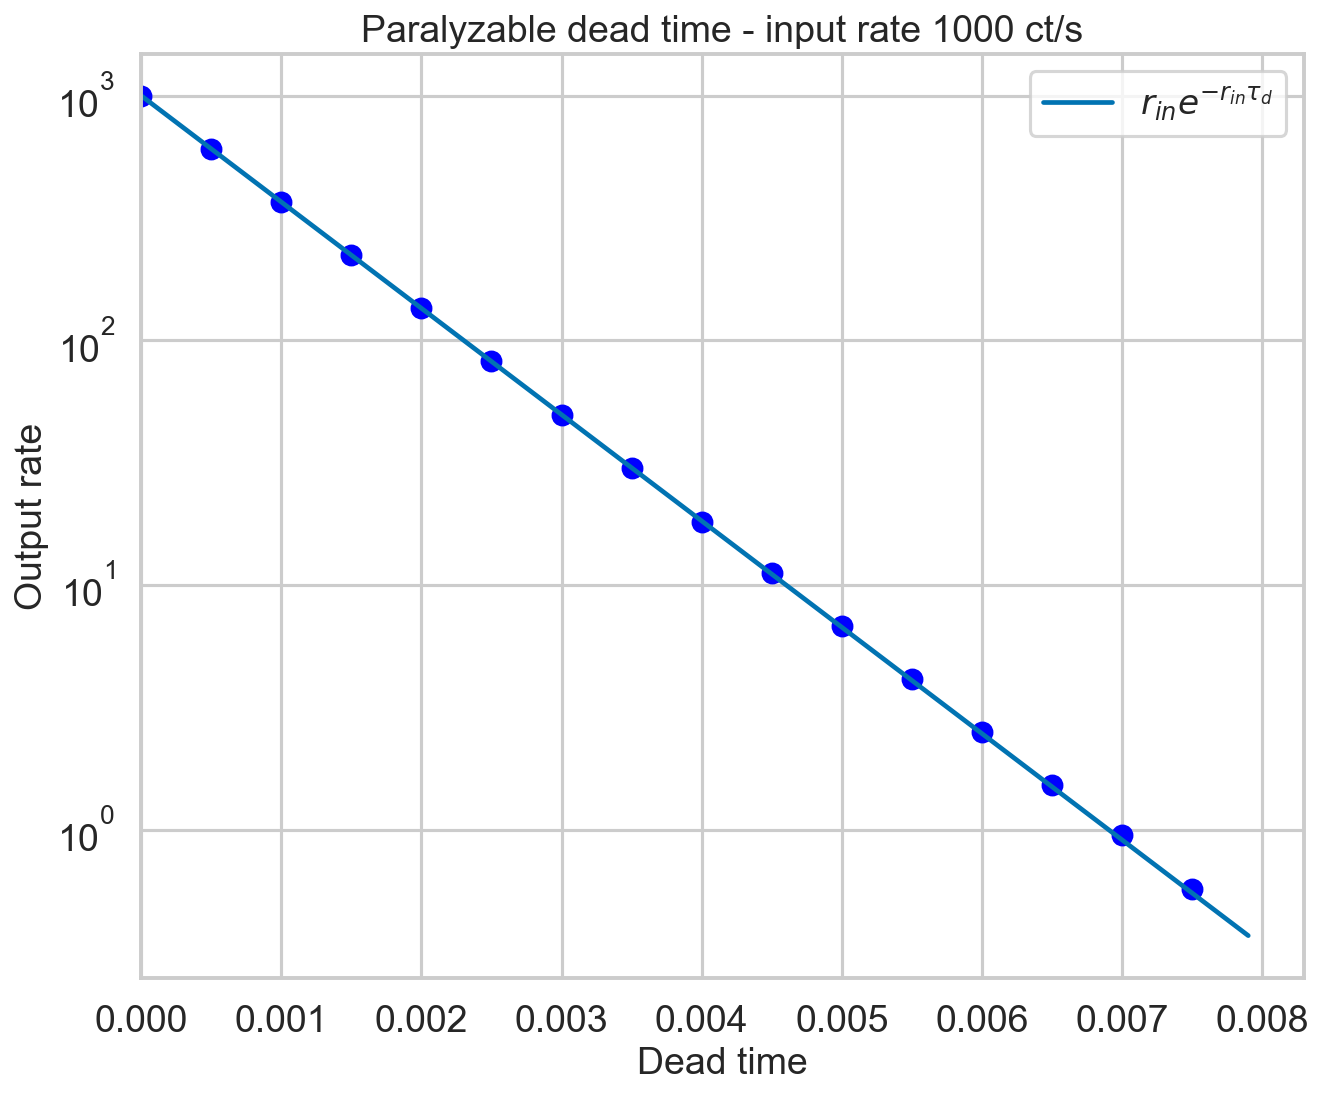

In [8]:
plt.figure()
plt.title('Paralyzable dead time - input rate {} ct/s'.format(rate))

deadtimes = np.arange(0, 0.008, 0.0005)
deadtimes_plot = np.arange(0, 0.008, 0.0001)

for d in deadtimes:
    events_dt = filter_for_deadtime(events, d, paralyzable=True)
    new_rate = len(events_dt) / length
    plt.scatter(d, new_rate, color='b')

plt.plot(deadtimes_plot, rate * np.exp(-rate * deadtimes_plot), 
         label=r'$r_{in}e^{-r_{in}\tau_d}$')
plt.xlim([0, None])
plt.xlabel('Dead time')
plt.ylabel('Output rate')
plt.semilogy()
plt.legend();

Perfect.

## Periodogram - non-paralyzable

Let's see how the periodogram behaves at different intensities. Will it follow the Zhang+95 model?

100%|████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.72it/s]


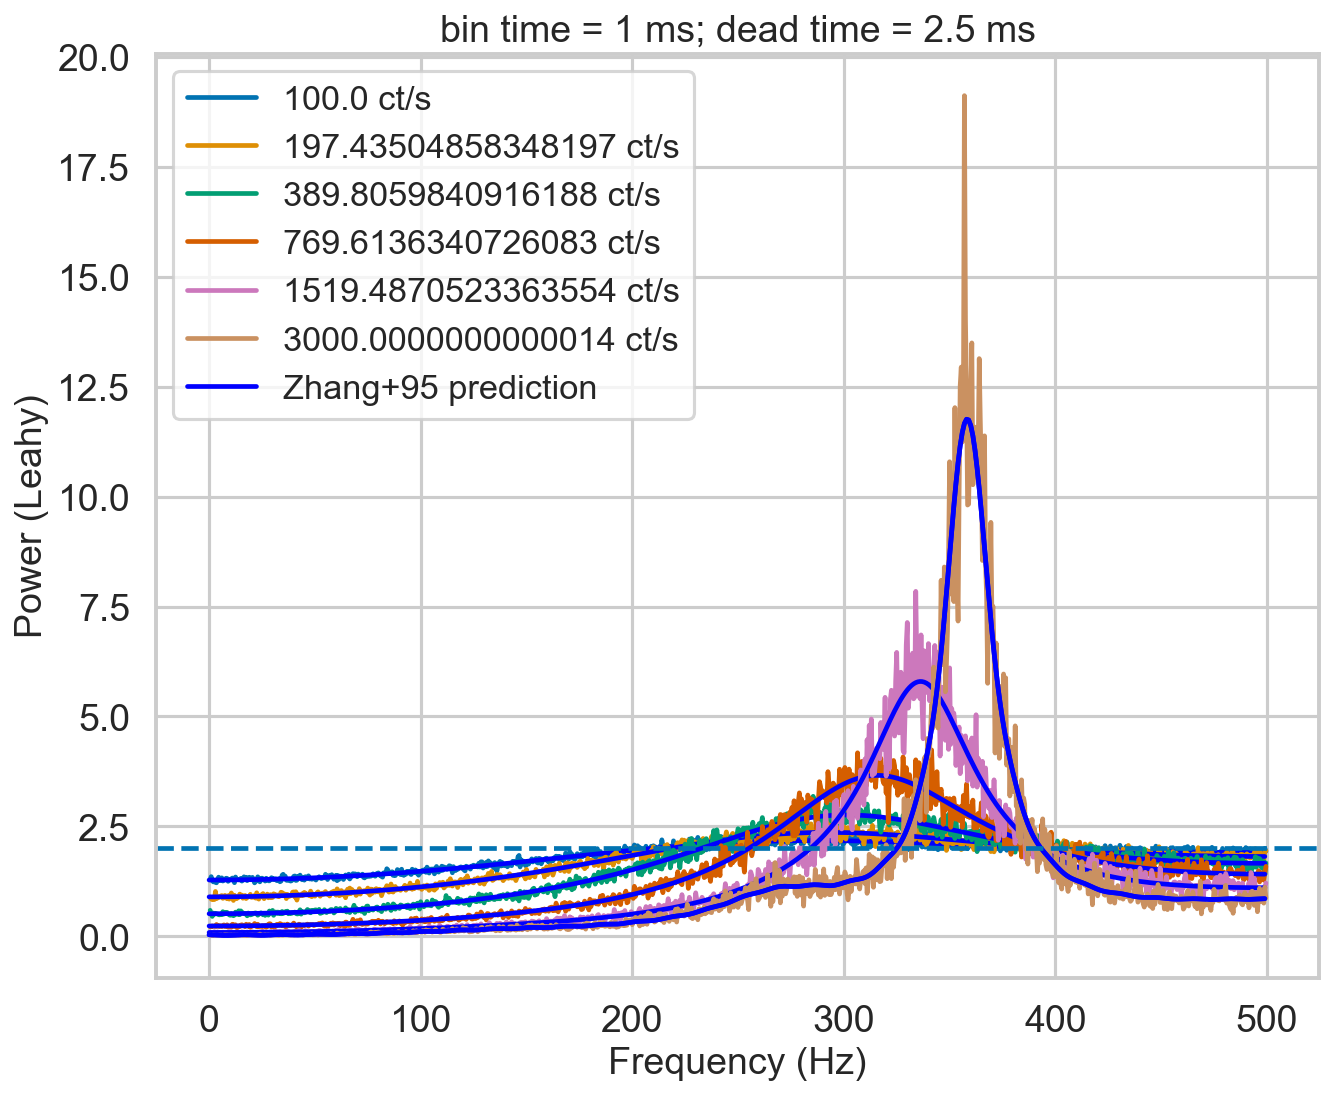

In [9]:
nevents = 200000

rates = np.logspace(2, np.log10(3000), 6)
bintime = 0.001
deadtime = 2.5e-3

plt.figure()
plt.title(f'bin time = 1 ms; dead time = 2.5 ms')
for r in tqdm.tqdm(rates):
    label = f'{r} ct/s'
    length = nevents / r

    events, events_dt = simulate_events(r, length)
    events_dt = EventList(events_dt, gti=[[0, length]])
#     lc = Lightcurve.make_lightcurve(events, 1/4096, tstart=0, tseg=length)
#     lc_dt = Lightcurve.make_lightcurve(events_dt, bintime, tstart=0, tseg=length)
#     pds = AveragedPowerspectrum.from_lightcurve(lc_dt, 2, norm='leahy')
    pds = AveragedPowerspectrum.from_events(events_dt, bintime, 2, norm='leahy', silent=True)
    plt.plot(pds.freq, pds.power, label=label)

    zh_f, zh_p = dz.pds_model_zhang(1000, r, deadtime, bintime)
    plt.plot(zh_f, zh_p, color='b')
plt.plot(zh_f, zh_p, color='b', label='Zhang+95 prediction')
plt.axhline(2, ls='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (Leahy)')
plt.legend();

100%|████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


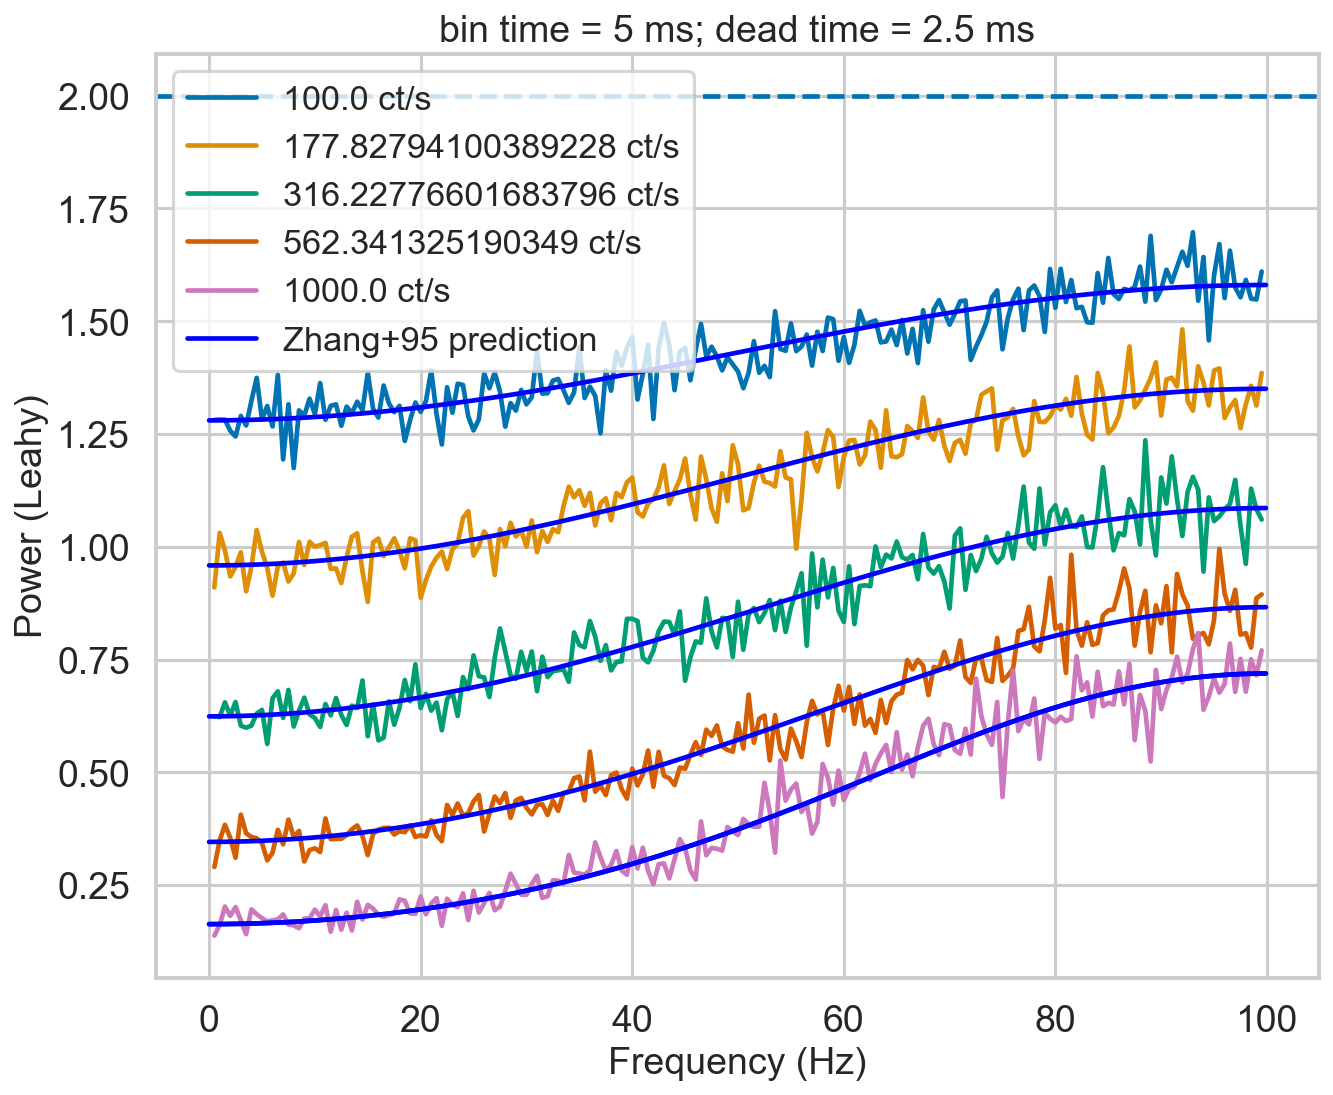

In [10]:
from stingray.lightcurve import Lightcurve
from stingray.powerspectrum import AveragedPowerspectrum
import tqdm

nevents = 200000

rates = np.logspace(2, 3, 5)
deadtime = 2.5e-3
bintime = 2 * deadtime


plt.figure()
plt.title(f'bin time = 5 ms; dead time = 2.5 ms')
for r in tqdm.tqdm(rates):
    label = f'{r} ct/s'
    length = nevents / r

    events, events_dt = simulate_events(r, length)
    events_dt = EventList(events_dt, gti=[[0, length]])
#     lc = Lightcurve.make_lightcurve(events, 1/4096, tstart=0, tseg=length)
#     lc_dt = Lightcurve.make_lightcurve(events_dt, bintime, tstart=0, tseg=length)
#     pds = AveragedPowerspectrum.from_lc(lc_dt, 2, norm='leahy', silent=True)
    pds = AveragedPowerspectrum.from_events(events_dt, bintime, 2, norm='leahy', silent=True)
    plt.plot(pds.freq, pds.power, label=label)

    zh_f, zh_p = dz.pds_model_zhang(2000, r, deadtime, bintime)
    plt.plot(zh_f, zh_p, color='b')
plt.plot(zh_f, zh_p, color='b', label='Zhang+95 prediction')

plt.axhline(2, ls='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (Leahy)')

plt.legend();

It will.

## Reproduce Zhang+95 power spectrum? (extra check)

4000it [00:00, 6396.64it/s]


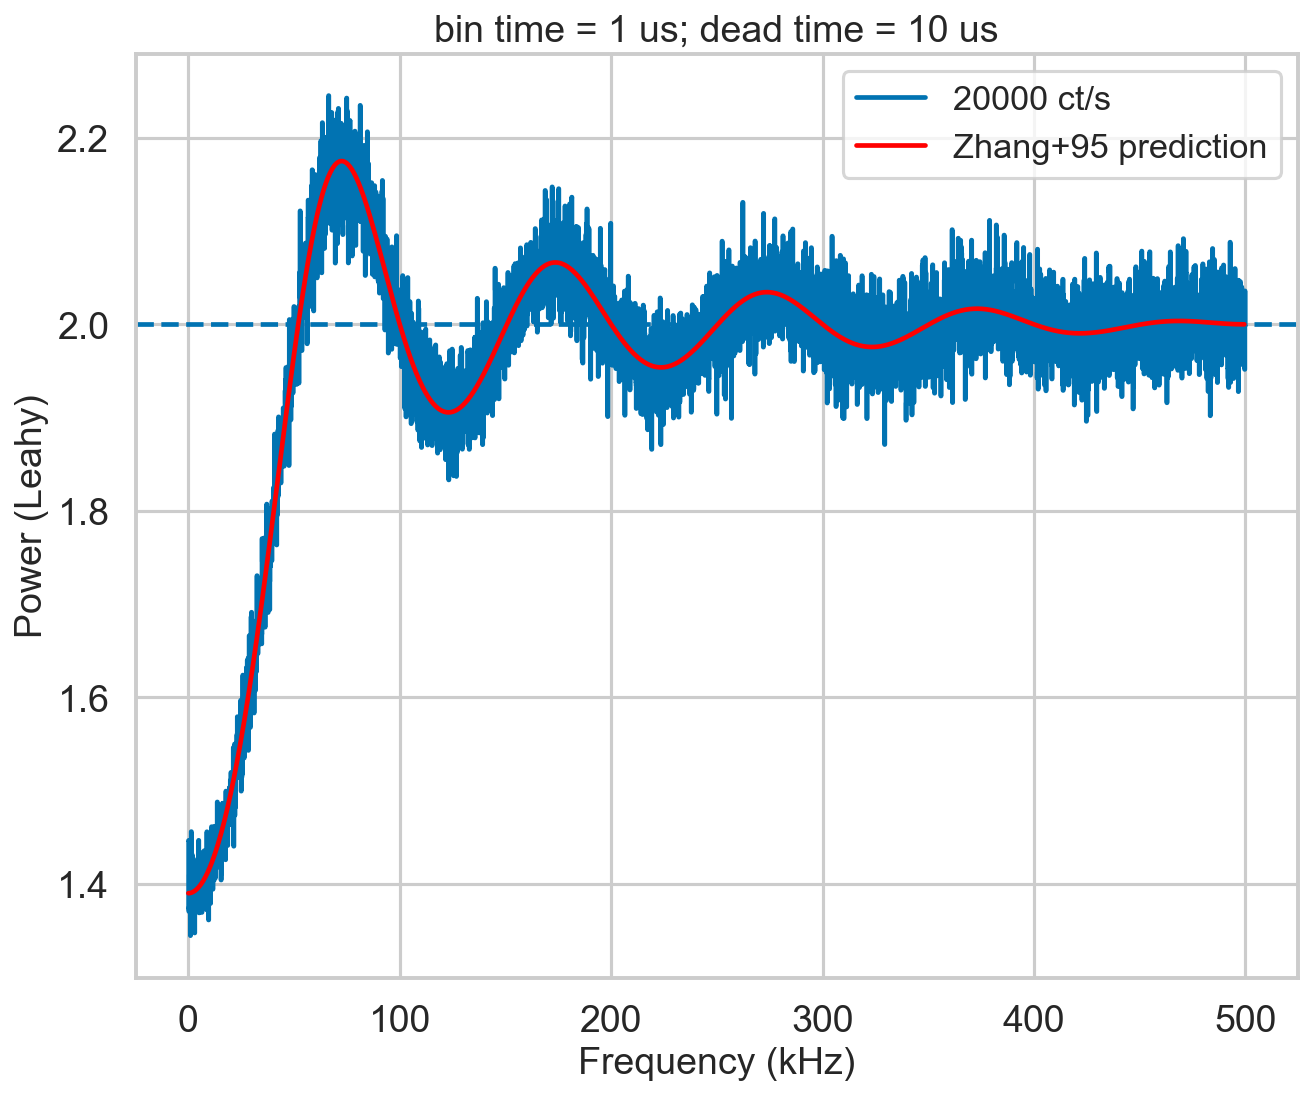

In [11]:
from stingray.lightcurve import Lightcurve
from stingray.powerspectrum import AveragedPowerspectrum
import tqdm

bintime = 1e-6
deadtime = 1e-5
length = 40
fftlen = 0.01

plt.figure()
plt.title(f'bin time = 1 us; dead time = 10 us')

r = 20000
label = f'{r} ct/s'

events, events_dt = simulate_events(r, length, deadtime=deadtime)
events_dt = EventList(events_dt, gti=[[0, length]])
#     lc = Lightcurve.make_lightcurve(events, 1/4096, tstart=0, tseg=length)
# lc_dt = Lightcurve.make_lightcurve(events_dt, bintime, tstart=0, tseg=length)
# pds = AveragedPowerspectrum.from_lightcurve(lc_dt, fftlen, norm='leahy')
pds = AveragedPowerspectrum.from_events(events_dt, bintime, fftlen, norm='leahy')
plt.plot(pds.freq / 1000, pds.power, label=label, drawstyle='steps-mid')

zh_f, zh_p = dz.pds_model_zhang(2000, r, deadtime, bintime)
plt.plot(zh_f / 1000, zh_p, color='r', label='Zhang+95 prediction', zorder=10)
plt.axhline(2, ls='--')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power (Leahy)')
plt.legend();

Ok.

An additional note on the Zhang model: it is a numerical model, with multiple nested summations that are prone to numerical errors. The assumptions made in the Zhang paper (along the line of "in practice the number of terms needed is very small…") are assuming the case of RXTE, where 1/dead time was low with respect to the incident rate. This is true in the simulation in figure 4 of Zhang+95: 20,000 ct/s incident rate, 1/dead time = 100,000. However, this is not true in NuSTAR, depicted in our simulation below where the incident rate (2,000) is much larger than 1/dead time (400). A thorough estimate of the needed level of detail (that implies increasing the number of summed terms) versus increase of numerical errors has to be done. This is a quite long procedure, and I did not go into so much detail. This is the reason of the “wiggles” that can be seen in the model in red in the plot below.


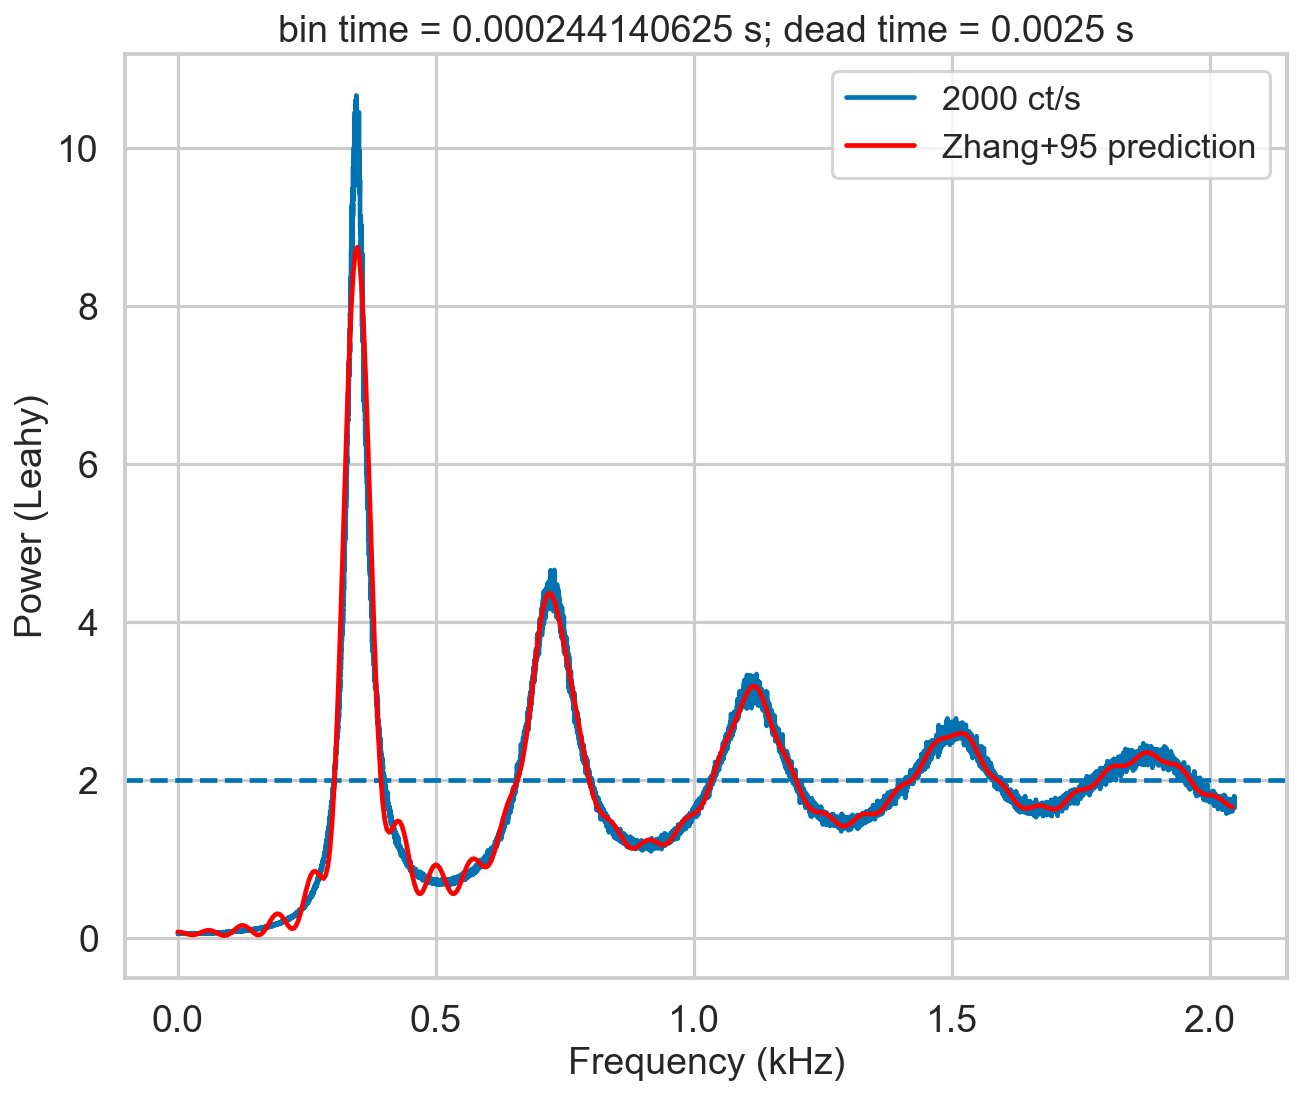

In [12]:
bintime = 1/4096
deadtime = 2.5e-3
length = 8000
fftlen = 5
r = 2000

plt.figure()

plt.title(f'bin time = {bintime} s; dead time = {deadtime} s')

label = f'{r} ct/s'

events, events_dt = simulate_events(r, length, deadtime=deadtime)
events_dt = EventList(events_dt, gti=[[0, length]])
#     lc = Lightcurve.make_lightcurve(events, 1/4096, tstart=0, tseg=length)
# lc_dt = Lightcurve.make_lightcurve(events_dt, bintime, tstart=0, tseg=length)
# pds = AveragedPowerspectrum.from_lightcurve(lc_dt, fftlen, norm='leahy', silent=True)
pds = AveragedPowerspectrum.from_events(events_dt, bintime, fftlen, norm='leahy', silent=True)
plt.plot(pds.freq / 1000, pds.power, label=label, drawstyle='steps-mid')

zh_f, zh_p = dz.pds_model_zhang(1000, r, deadtime, bintime)
plt.plot(zh_f / 1000, zh_p, color='r', label='Zhang+95 prediction', zorder=10)
plt.axhline(2, ls='--')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power (Leahy)')
plt.legend();

The script `check_A` checks visually the number of `k`s to calculate before going to the approximate value `r0**2*tb**2`. The default is 60, but in this case the presence of additional modulation for k=60 tells us that we need to increase the limit of calculated `A_k` to at least 150.
The script `check_B` does this for another important quantity in the model.

Somewhat counter-intuitively, there might be cases where too _high_ values of k could produce numerical errors. Always run `check_A` and `check_B` to test it.

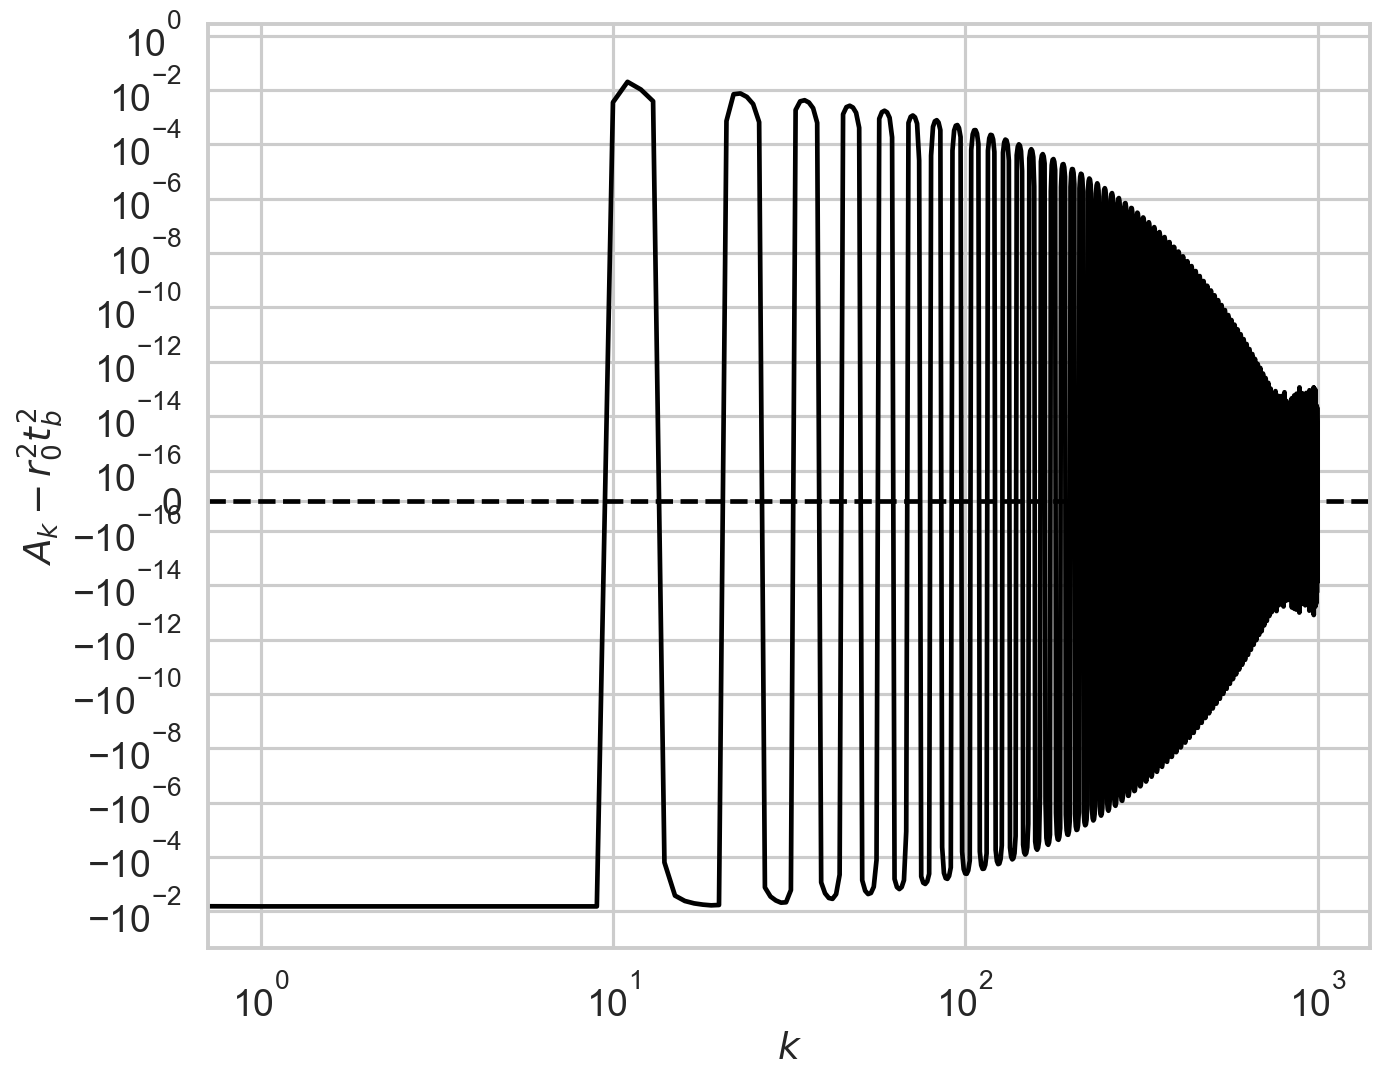

In [13]:
def safe_A(k, r0, td, tb, tau, limit=60):
    if k > limit:
        return r0 ** 2 * tb**2
    return A(k, r0, td, tb, tau)


check_A(r, deadtime, bintime, max_k=1000, linthresh=1e-16);

So, we had better repeat the procedure by using `limit_k=500` this time.

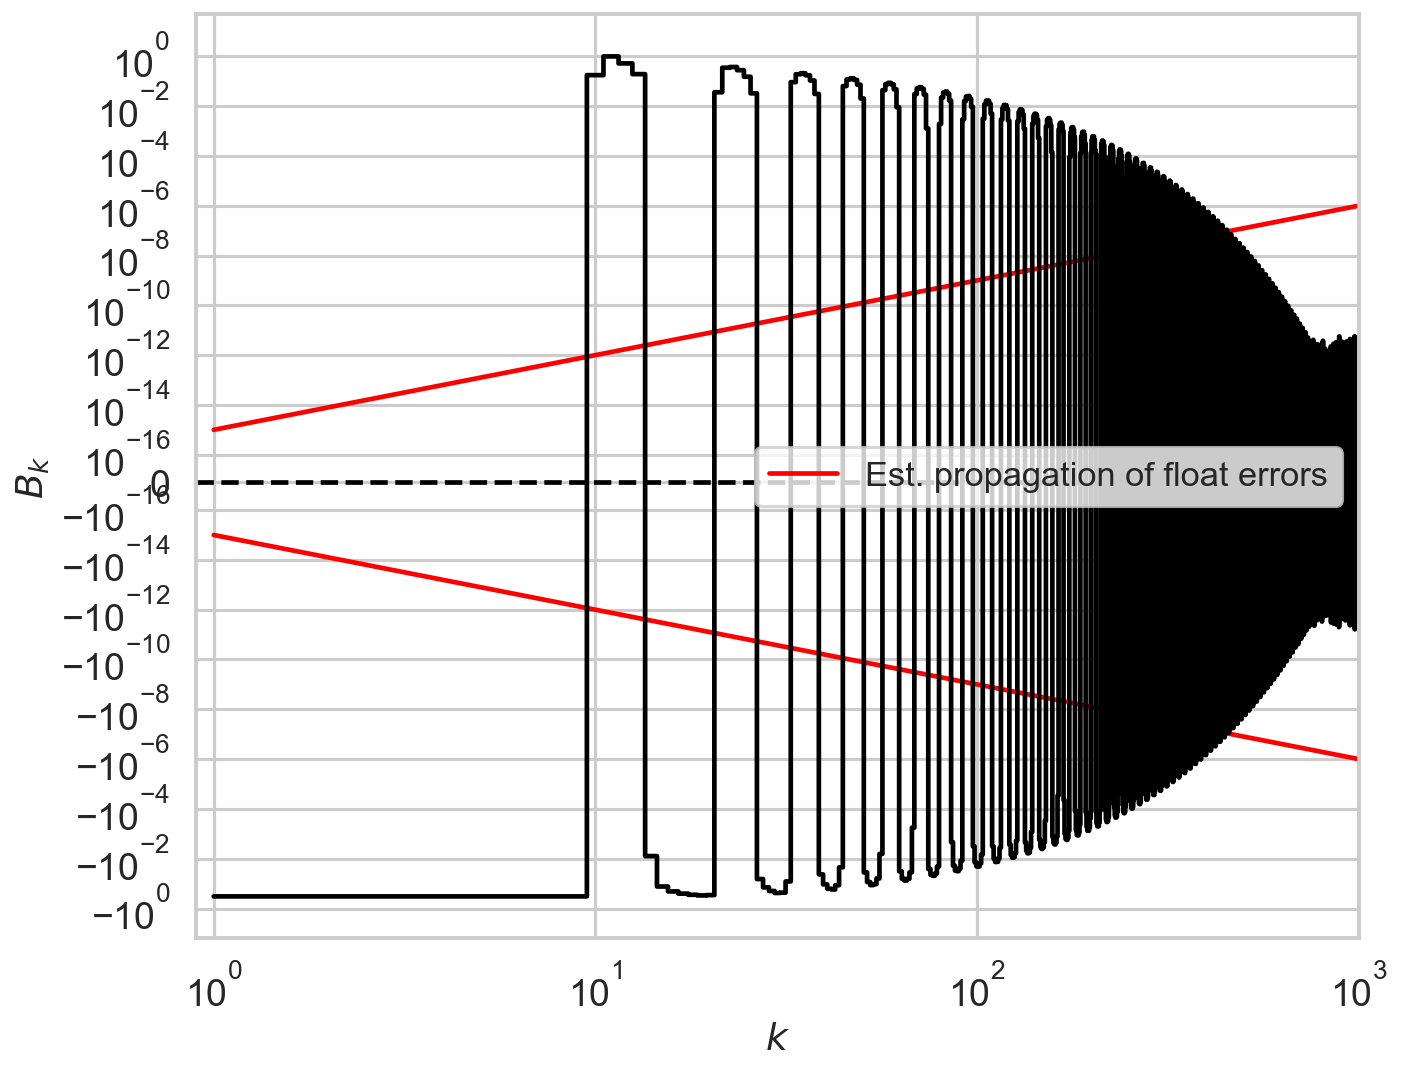

In [14]:
check_B(r, deadtime, bintime, max_k=1000, linthresh=1e-16);

1600it [00:00, 3036.28it/s]


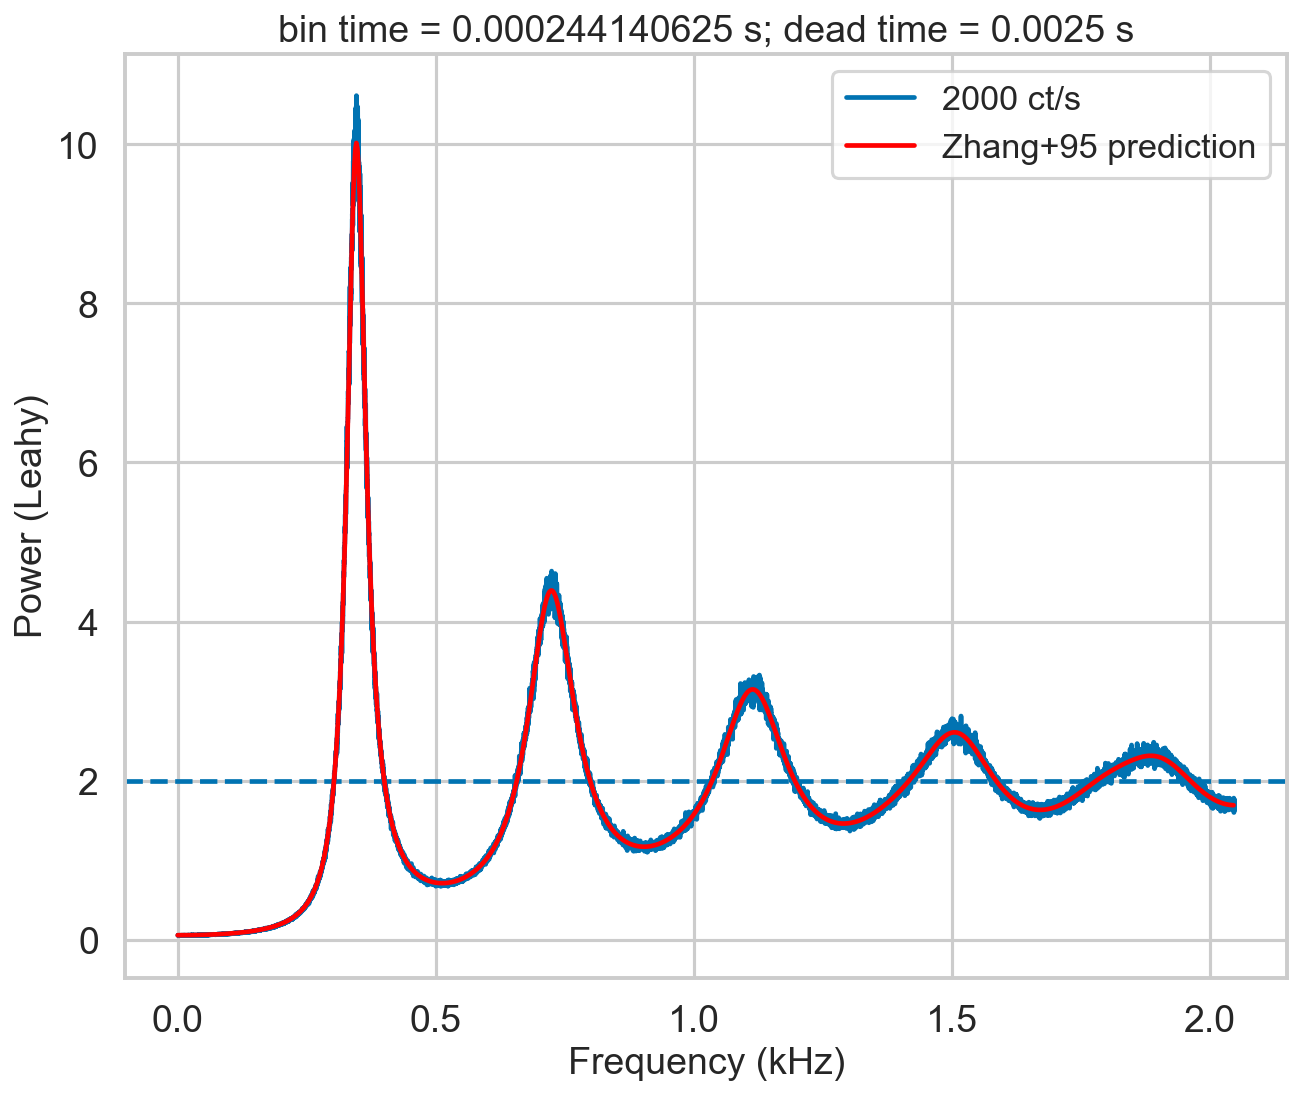

In [15]:
bintime = 1/4096
deadtime = 2.5e-3
length = 8000
fftlen = 5
r = 2000

plt.figure()

plt.title(f'bin time = {bintime} s; dead time = {deadtime} s')

label = f'{r} ct/s'

events, events_dt = simulate_events(r, length, deadtime=deadtime)
events_dt = EventList(events_dt, gti=[[0, length]])
#     lc = Lightcurve.make_lightcurve(events, 1/4096, tstart=0, tseg=length)
# lc_dt = Lightcurve.make_lightcurve(events_dt, bintime, tstart=0, tseg=length)
# pds = AveragedPowerspectrum(lc_dt, fftlen, norm='leahy')
# lc_dt = Lightcurve.make_lightcurve(events_dt, bintime, tstart=0, tseg=length)
pds = AveragedPowerspectrum.from_events(events_dt, bintime, fftlen, norm='leahy')
plt.plot(pds.freq / 1000, pds.power, label=label, drawstyle='steps-mid')

zh_f, zh_p = dz.pds_model_zhang(2000, r, deadtime, bintime, limit_k=500)
plt.plot(zh_f / 1000, zh_p, color='r', label='Zhang+95 prediction', zorder=10)
plt.axhline(2, ls='--')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power (Leahy)')
plt.legend();

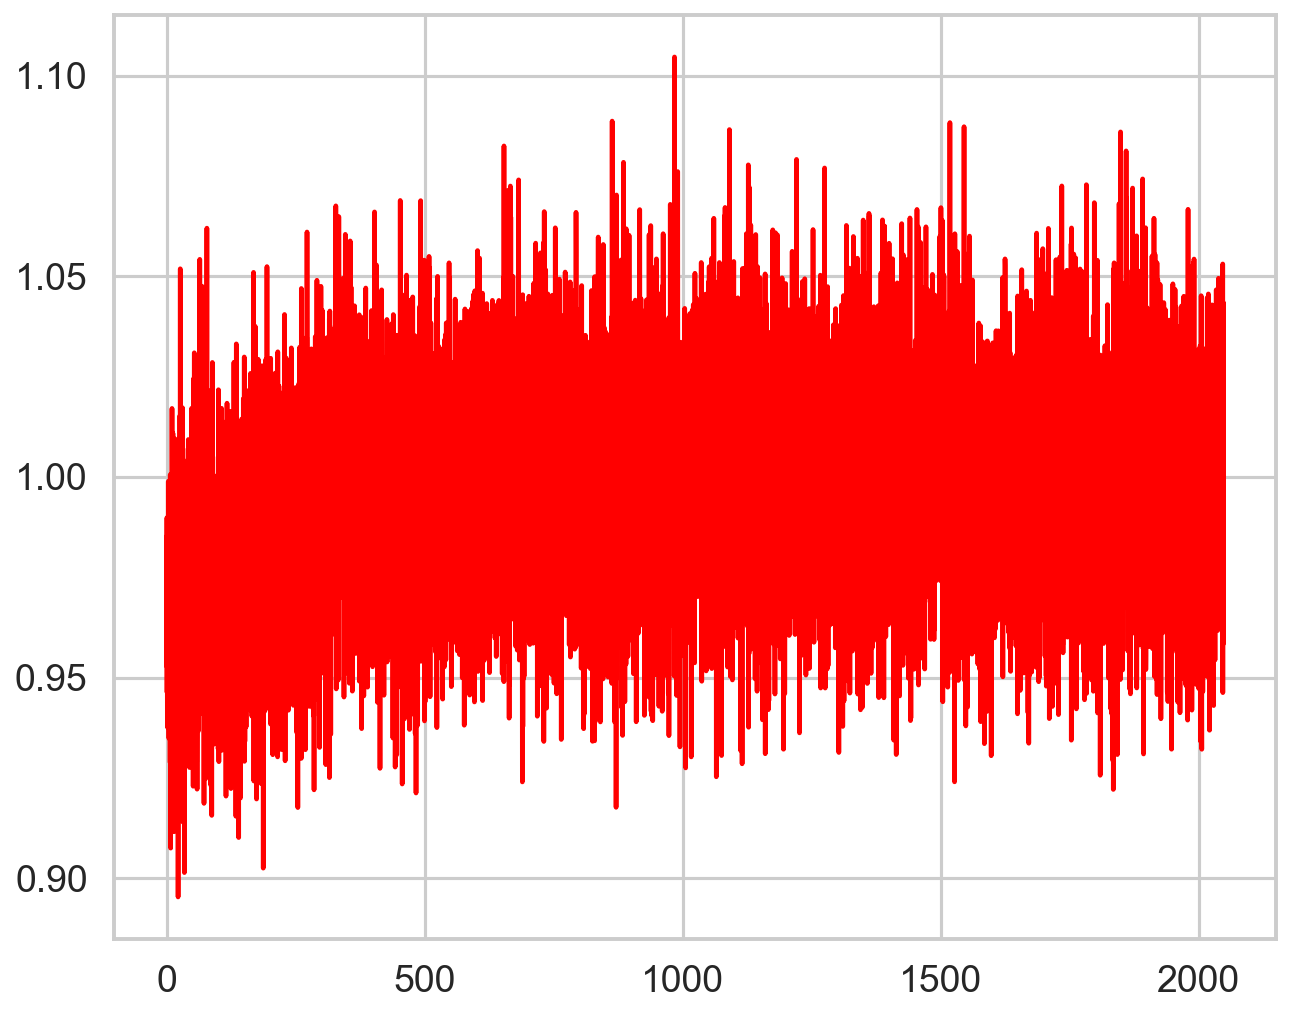

In [16]:
from scipy.interpolate import interp1d

deadtime_fun = interp1d(zh_f, zh_p, bounds_error=False,fill_value="extrapolate")

plt.figure()
plt.plot(pds.freq, pds.power / deadtime_fun(pds.freq), color='r', zorder=10)


Still imperfect, but this is a _very_ high count rate case. In more typical cases, the correction is more than adequate:

1600it [00:00, 2957.61it/s]


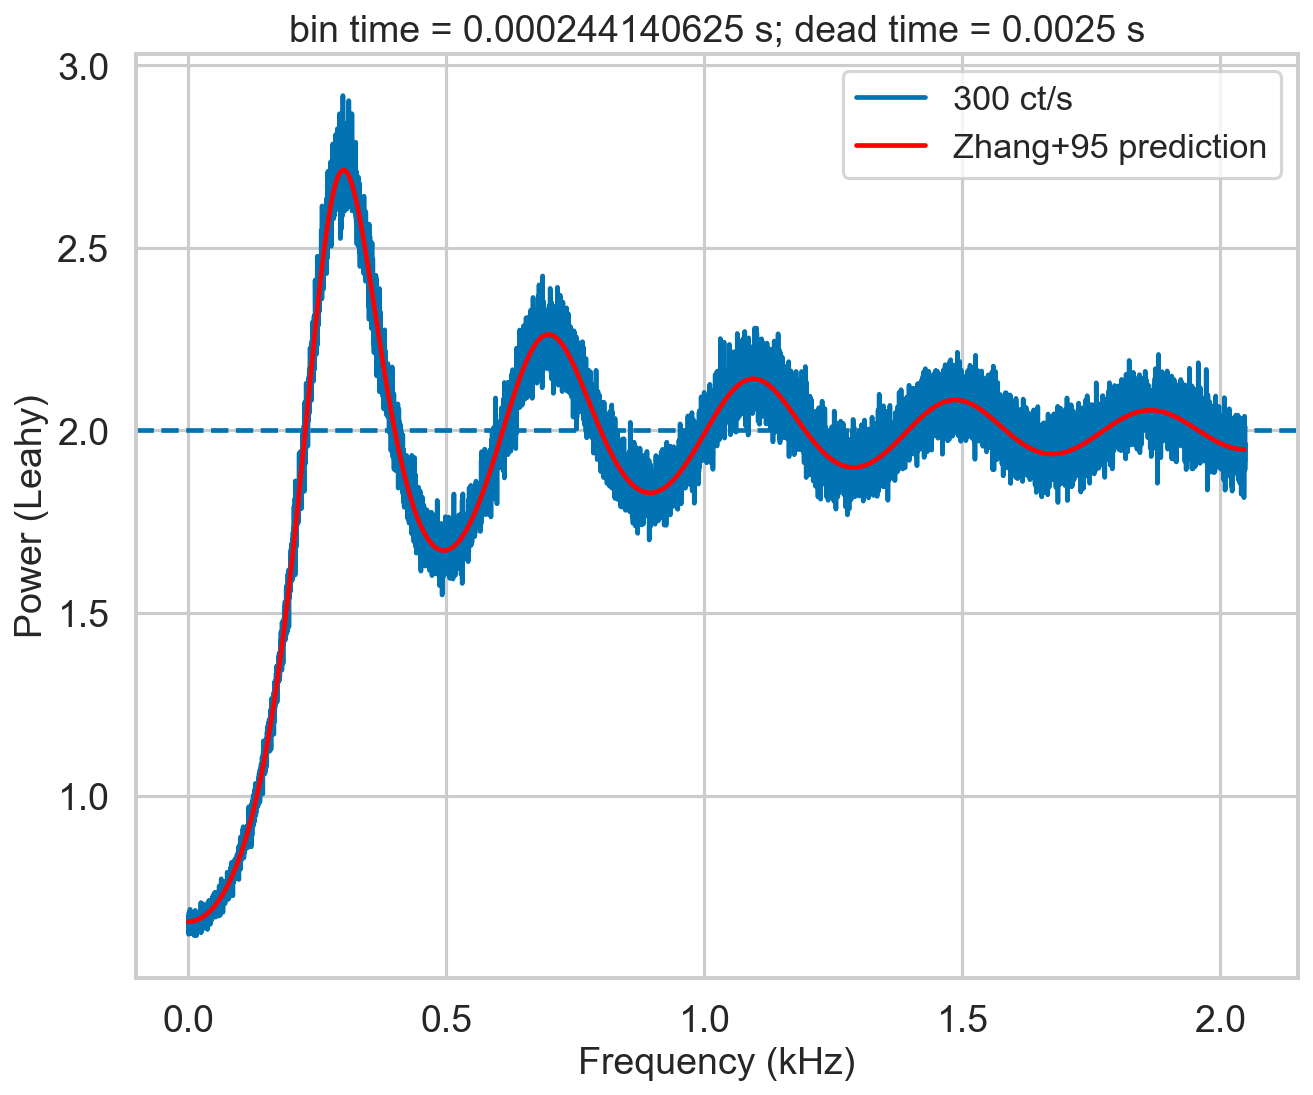

In [17]:
bintime = 1/4096
deadtime = 2.5e-3
length = 8000
fftlen = 5
r = 300

plt.figure()

plt.title(f'bin time = {bintime} s; dead time = {deadtime} s')

label = f'{r} ct/s'

events, events_dt = simulate_events(r, length, deadtime=deadtime)
events_dt = EventList(events_dt, gti=[[0, length]])
#     lc = Lightcurve.make_lightcurve(events, 1/4096, tstart=0, tseg=length)
# lc_dt = Lightcurve.make_lightcurve(events_dt, bintime, tstart=0, tseg=length)
# pds = AveragedPowerspectrum(lc_dt, fftlen, norm='leahy')
pds = AveragedPowerspectrum.from_events(events_dt, bintime, fftlen, norm='leahy')
plt.plot(pds.freq / 1000, pds.power, label=label, drawstyle='steps-mid')

zh_f, zh_p = dz.pds_model_zhang(2000, r, deadtime, bintime, limit_k=250)
plt.plot(zh_f / 1000, zh_p, color='r', label='Zhang+95 prediction', zorder=10)
plt.axhline(2, ls='--')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power (Leahy)')
plt.legend();

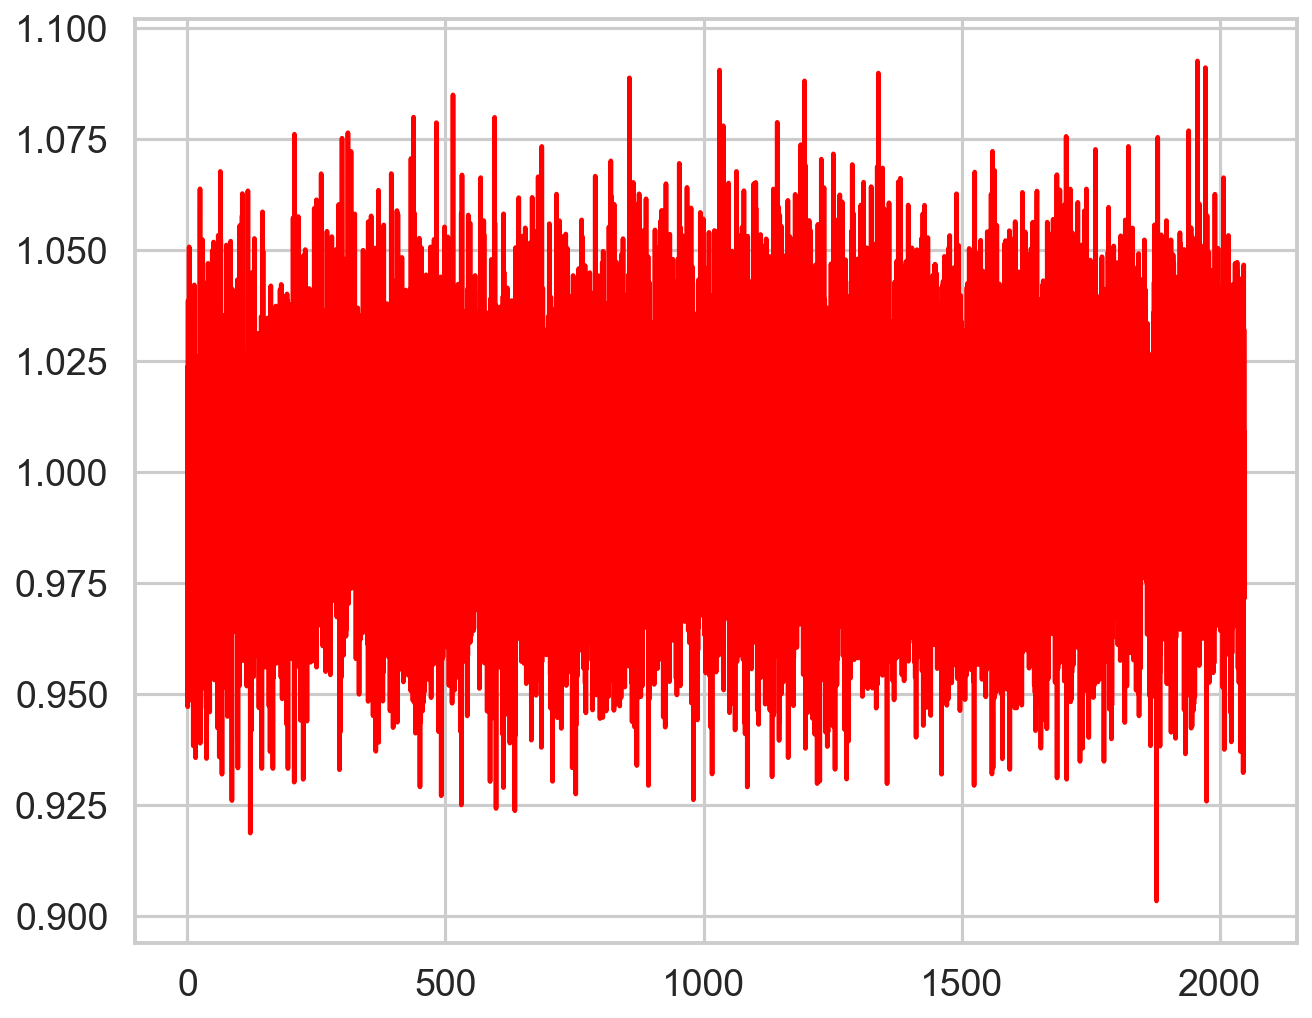

In [18]:
deadtime_fun = interp1d(zh_f, zh_p, bounds_error=False,fill_value="extrapolate")

plt.figure()
plt.plot(pds.freq, pds.power / deadtime_fun(pds.freq), color='r', zorder=10)


## New dead time model function

Stingray versions >2.0 introduce a new formulation of the dead time modeling, which includes:

1) Using detected rates, not incident (which means, the rates that the user can actually measure!)
2) Allowing for background rates (e.g. the events which produce dead time but get filtered away during source selection or other filtering processes)

In [19]:
from stingray.deadtime.model import non_paralyzable_dead_time_model
non_paralyzable_dead_time_model?

Signature:
non_paralyzable_dead_time_model(
    freqs,
    dead_time,
    rate,
    bin_time=None,
    limit_k=200,
    background_rate=0.0,
    n_approx=None,
)
Docstring:
Calculate the dead-time-modified power spectrum.

Parameters
----------
freqs : array of floats
    Frequency array
dead_time : float
    Dead time
rate : float
    Detected source count rate

Other Parameters
----------------
bin_time : float
    Bin time of the light curve
limit_k : int, default 200
    Limit to this value the number of terms in the inner loops of
    calculations. Check the plots returned by  the `check_B` and
    `check_A` functions to test that this number is adequate.
background_rate : float, default 0
    Detected background count rate. This is important to estimate when deadtime is given by the
    combination of the source counts and background counts (e.g. in an imaging X-ray detector).
n_approx : int, default None
    Number of bins to calculate the model power spectrum. If None, it will 

10000it [00:00, 25078.61it/s]


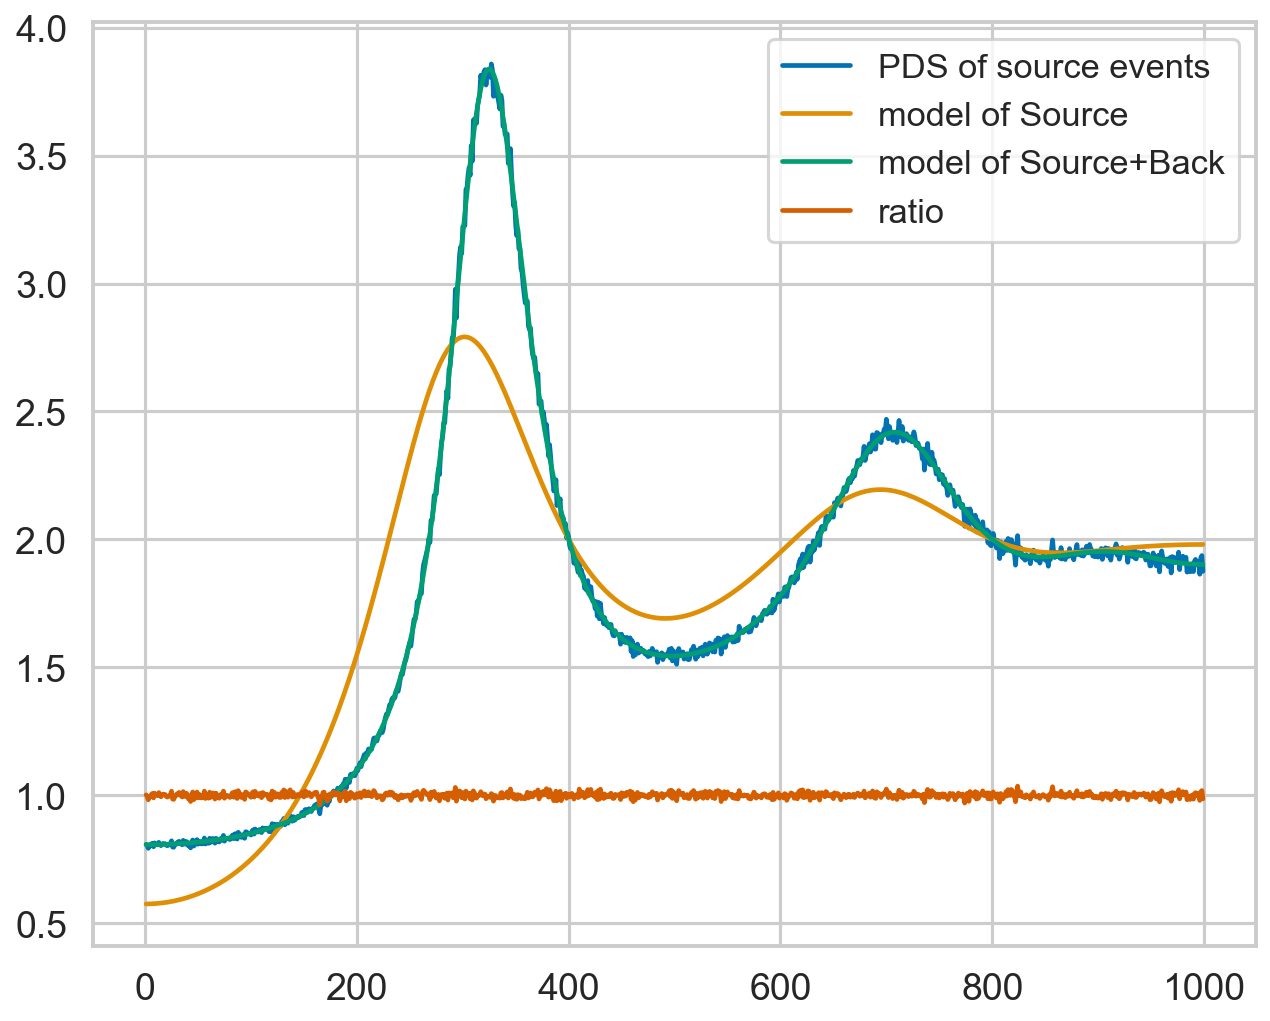

In [20]:
rate = 1000
tmax = 10000
deadtime = 2.5e-3
dt = 0.0005
segment_size = 1
import copy
source_fraction = 0.65

def split_between_source_and_background(times, source_fraction):
    times_shuf = copy.deepcopy(times)
    np.random.shuffle(times_shuf)
    times_source = np.sort(times_shuf[: int(source_fraction * times.size)])
    times_bkg = np.sort(times_shuf[int(source_fraction * times.size): ])
    return times_source, times_bkg


times = np.sort(np.random.uniform(0, tmax, rate * tmax))
times_dt = filter_for_deadtime(times, deadtime)

times_source_dt, times_bkg_dt = split_between_source_and_background(times_dt, source_fraction)

source_rate = source_fraction * rate

pds_source_dt = AveragedPowerspectrum.from_time_array(times_source_dt, gti=[[0, tmax]], dt=dt, segment_size=1, norm="leahy")

model_source_nobkg = non_paralyzable_dead_time_model(
    pds_source_dt.freq, 
    dead_time=deadtime, 
    rate=times_source_dt.size / tmax, 
    bin_time=dt
)

model_source_corr = non_paralyzable_dead_time_model(
    pds_source_dt.freq, 
    dead_time=deadtime, 
    rate=times_source_dt.size / tmax, 
    bin_time=dt,
    background_rate=times_bkg_dt.size / tmax, 
)

plt.plot(pds_source_dt.freq, pds_source_dt.power, label="PDS of source events")
plt.plot(pds_source_dt.freq, model_source_nobkg, zorder=10, label="model of Source")
plt.plot(pds_source_dt.freq, model_source_corr, zorder=10, label="model of Source+Back")
plt.plot(pds_source_dt.freq, pds_source_dt.power / model_source_corr, zorder=10, label="ratio")

plt.legend(loc="upper right")

Text(0, 0.5, 'PDS / model')

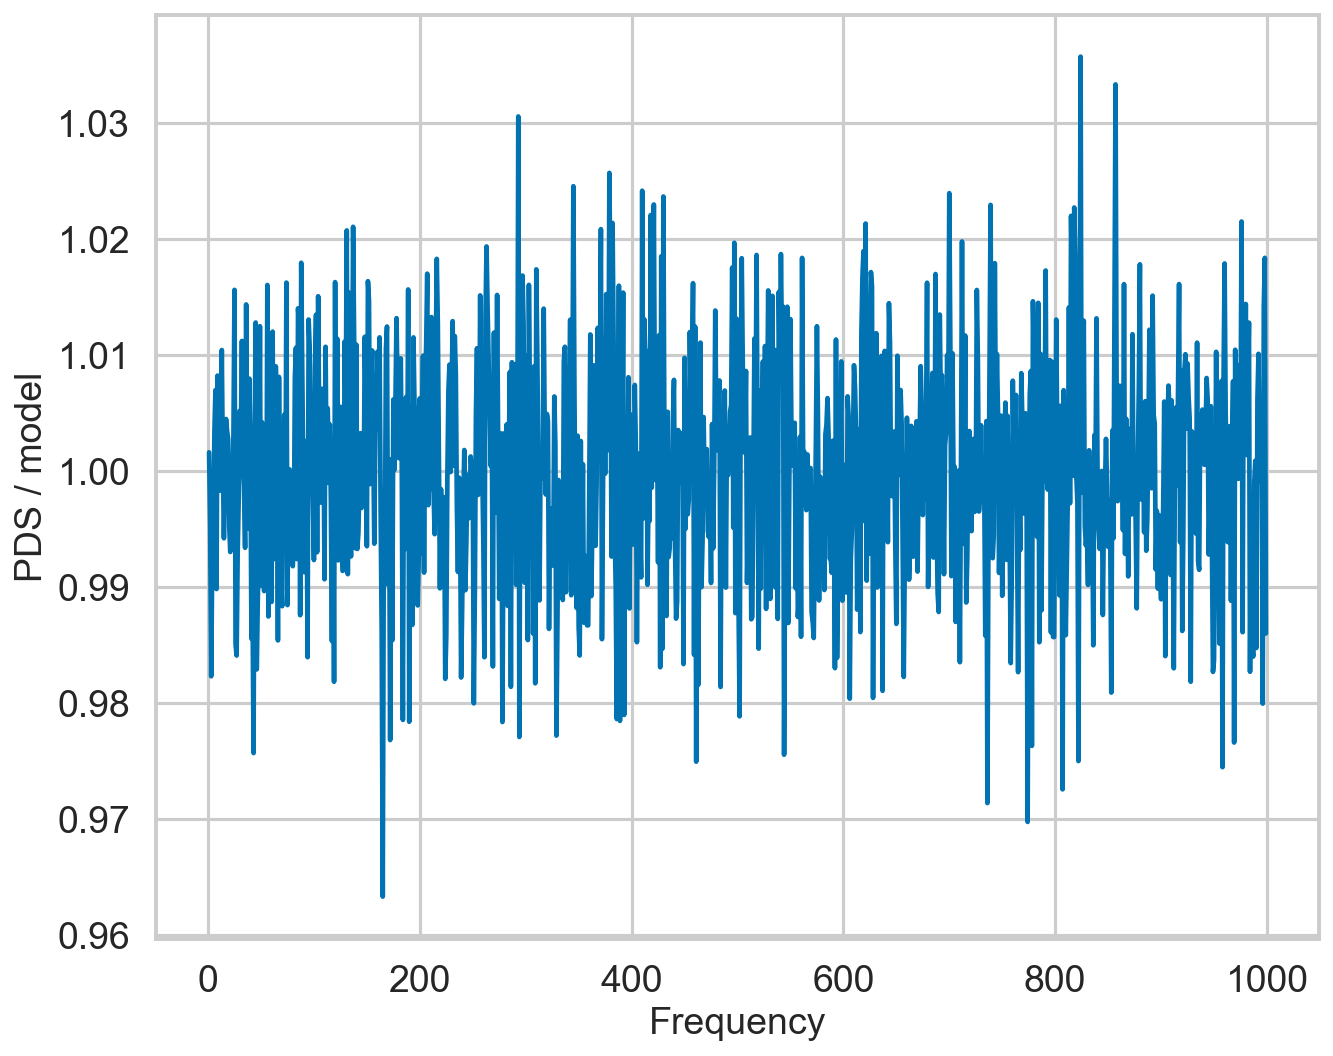

In [21]:
plt.plot(pds_source_dt.freq, pds_source_dt.power / model_source_corr, zorder=10, label="ratio")
plt.xlabel("Frequency")
plt.ylabel("PDS / model")

The function is also used internally in some timing products, to easily correct the spectrum, through the method `deadtime_correct`. Please note that the example below works a little too well because, in our simulation, dead time is constant. In general, this correction is appropriate for relatively low values of _constant_ deadtime, while we recommend using the FAD correction from `stingray.deadtime.fad` for variable dead time and high count rates.

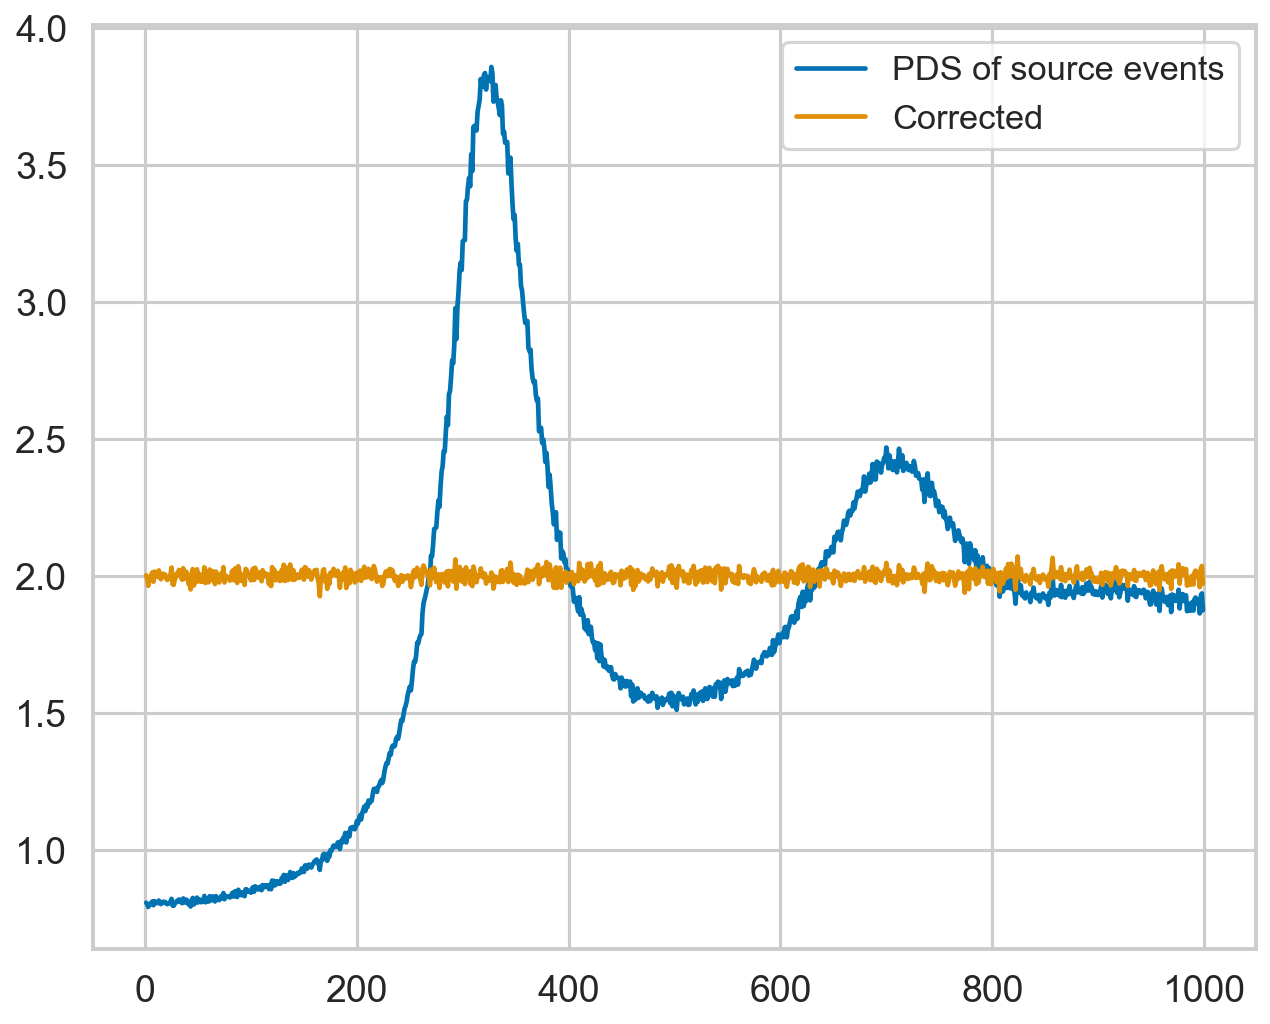

In [22]:
pds_source_corrected = pds_source_dt.deadtime_correct(dead_time=deadtime, 
    rate=times_source_dt.size / tmax, 
    background_rate=times_bkg_dt.size / tmax)

plt.plot(pds_source_dt.freq, pds_source_dt.power, label="PDS of source events")
plt.plot(pds_source_corrected.freq, pds_source_corrected.power, zorder=10, label="Corrected")

plt.legend(loc="upper right");
